<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Sepehr Harfi
### Student Number : 99109552
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [34]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

import tqdm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
  ]) # Write your code here

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
batch_size = 16

train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=True, num_workers=2,
    ) # Write your code here
val_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=batch_size, shuffle=True, num_workers=2, 
    ) # Write your code here
    

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [64]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class Block(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, 
                               stride=stride, padding='same', bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding='same', bias=False)

        self.shortcut = nn.Sequential()
        
        if in_planes != planes or stride != 1:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, planes,
                kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(planes))

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = out + self.shortcut(x)
        return out

class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, 
                               stride=1, padding='same', bias=False)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, 
                               stride=1, padding='same', bias=False)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(64, 10)
        self.first_block = Block(16, 16)
        self.sec_block = Block(64, 64)

    def forward(self, x):
      out = self.conv1(x)
      out = F.relu(out)
      out = F.max_pool2d(out, 2)
      out = self.first_block(out)
      out = F.max_pool2d(out, 2)
      out = self.conv2(out)
      out = F.relu(out)
      out = self.sec_block(out)
      out = self.avg_pool(out)
      out = torch.flatten(out, start_dim=1)
      out = self.linear(out)
      return out 
        

# Train Model (30 Points)

In [65]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
import torch.optim as optim

net = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss() # Write your code here
optimizer = optim.SGD(net.parameters(), lr=9e-3,
                      momentum=0.87, weight_decay=5e-4) # Write your code here

In [66]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
torch.autograd.set_detect_anomaly(True)
total_step = len(train_loader)
num_epochs = 10

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0
    dataloader = train_loader
    net.train()
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = net(x)

            loss = criterion(p, y)
            epoch_loss += float(loss)

            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            pbar.set_description(f'Train: Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
    train_loss.append(epoch_loss / len(dataloader))
    train_acc.append((epoch_true * 100. / epoch_all).item())
    

    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0
    dataloader = val_loader
    net.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = net(x)

            loss = criterion(p, y)
            epoch_loss += float(loss)

            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            pbar.set_description(f'Val: Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')

    val_loss.append(epoch_loss / len(dataloader))
    val_acc.append((epoch_true * 100. / epoch_all).item())

Val: Loss: 5.306e-02 - Acc: 98.37%: 100%|██████████| 625/625 [00:05<00:00, 123.43it/s]


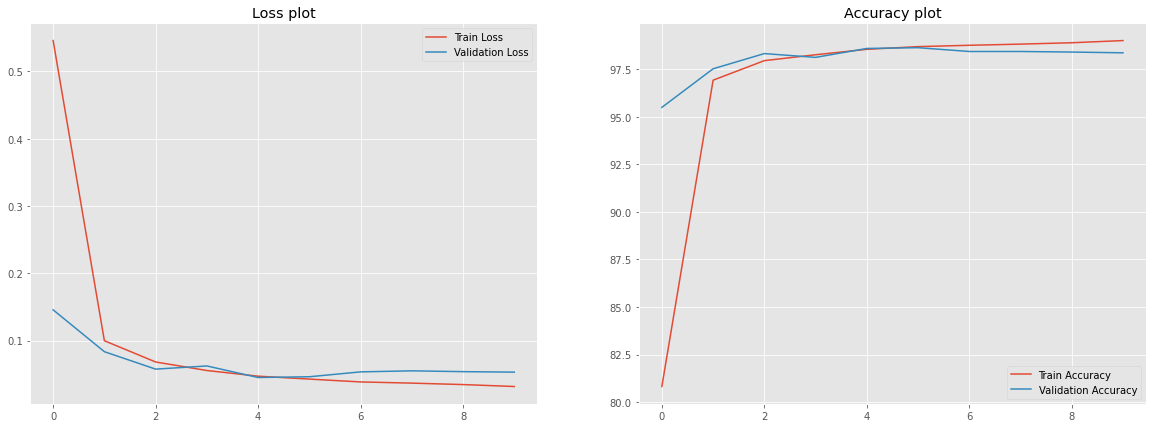

In [67]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
epoch_list = [i for i in range(num_epochs)]

fig = plt.figure(figsize=(20, 7))

fig.add_subplot(1, 2, 2)
plt.plot(epoch_list, train_acc)
plt.plot(epoch_list, val_acc)
plt.title('Accuracy plot')
plt.legend(['Train Accuracy', 'Validation Accuracy'])

fig.add_subplot(1, 2, 1)
plt.plot(epoch_list, train_loss)
plt.plot(epoch_list, val_loss)
plt.title('Loss plot')
plt.legend(['Train Loss', 'Validation Loss'])

plt.show()

# Test Model (20 Points)

In [68]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

epoch_loss = 0
epoch_true = 0
epoch_all = 0
i = 0
dataloader = test_loader
net.eval()
tot_labels = []
tot_pred = []

with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
    for i, (x, y) in pbar:
        x = x.to(device)
        y = y.to(device)
        p = net(x)

        loss = criterion(p, y)
        epoch_loss += float(loss)

        predictions = p.argmax(-1)
        epoch_all += len(predictions)
        epoch_true += (predictions == y).sum()

        tot_labels= np.concatenate([tot_labels, y.cpu().detach().numpy()])
        tot_pred = np.concatenate([tot_pred, predictions.cpu().detach().numpy()])

        pbar.set_description(f'Val: Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')

test_loss = epoch_loss / len(dataloader)
test_acc = (epoch_true * 100. / epoch_all).item()

10000


Val: Loss: 3.477e-02 - Acc: 98.77%: 100%|██████████| 157/157 [00:02<00:00, 58.00it/s]


<function matplotlib.pyplot.show(*args, **kw)>

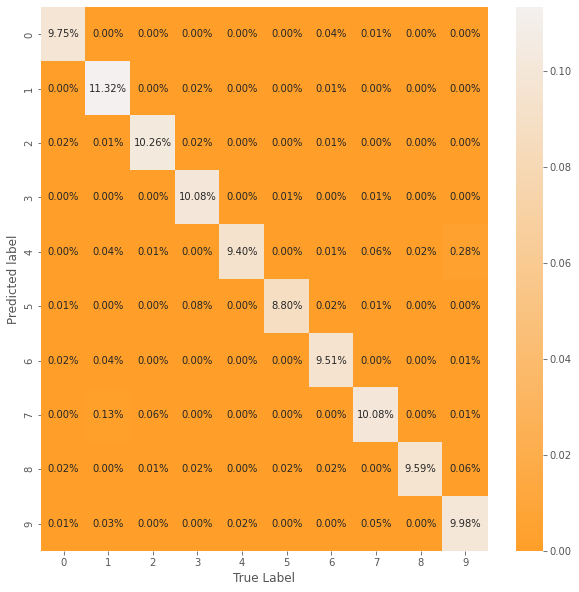

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(10,10)) 
clr_plt = sns.light_palette("#FF9F29", reverse=True, as_cmap=True)
cf_matrix = confusion_matrix(tot_labels, tot_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%',cmap=clr_plt, ax=ax)  
plt.ylabel('Predicted label')
plt.xlabel('True Label')
plt.show